#### Sales Prediction for Groceries
##### Since sales distribution for Grocery Type was much lower compared to Super Markets, we will model create separate models for Grocey and other Supermarket types

In [2]:
# # Install the below packages
# !pip install xgboost
# !pip install xgboost lightgbm
# !pip install catboost

In [3]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.ensemble import RandomForestRegressor
import scipy.stats as stats
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

warnings.filterwarnings("ignore")

In [4]:
# Read train data
train_data = pd.read_csv("../data/train_v9rqX0R.csv")

##### Data Cleaning & Feature Engineering

In [6]:
# Outlet Size - missing value imputation
train_data["Units"] = train_data["Item_Outlet_Sales"]/train_data["Item_MRP"]
outlet_df = train_data.groupby(["Outlet_Identifier","Outlet_Location_Type","Outlet_Type","Outlet_Size"],as_index=False,dropna=False).agg(
    total_sales=("Item_Outlet_Sales","sum"),
    Units=("Units","sum")
)
outlet_df.sort_values(by=['Outlet_Location_Type','Outlet_Type'])

,Outlet_Identifier,Outlet_Location_Type,Outlet_Type,Outlet_Size,total_sales,Units
4,OUT019,Tier 1,Grocery Store,Small,1.796941e+05,1290.777461
8,OUT046,Tier 1,Supermarket Type1,Small,2.118395e+06,15057.629973
9,OUT049,Tier 1,Supermarket Type1,Medium,2.183970e+06,15466.172404
2,OUT017,Tier 2,Supermarket Type1,NaN,2.167465e+06,15427.104933
6,OUT035,Tier 2,Supermarket Type1,Small,2.268123e+06,15785.754166
7,OUT045,Tier 2,Supermarket Type1,NaN,2.036725e+06,14475.949402
0,OUT010,Tier 3,Grocery Store,NaN,1.883402e+05,1322.692377
1,OUT013,Tier 3,Supermarket Type1,High,2.142664e+06,14913.254377
3,OUT018,Tier 3,Supermarket Type2,Medium,1.851823e+06,12854.383093
5,OUT027,Tier 3,Supermarket Type3,Medium,3.453926e+06,24879.398075


##### Imputation Assumptions
###### 1. For grocery outlet "OUT010", the sales and units sold are similar to the other grocery store "OUT019" which is tagged as "Small". Hence, it is safe to assume that "OUT010" could be a small size grocery store
###### 2. In Tier 2 location type, "OUT035" had the highest sales and units sold and it was tagged as "Small". The other 2 outlets have lesser sales and units sold and they could be safely assumed to be small size supermarkets
###### 3. Hence, all the 3 outlets missing Outlet Size can be tagged as 'Small'

In [8]:
# Cleaning functions
def extract_category(df):
    """ Extract the first 2 characters from item ID as category"""
    df["Item_Category"] = df["Item_Identifier"].str[0:2]
    return df

def clean_fat_content(df):
    """ Clean inconsistent categories in item fat content"""
    df["Item_Fat_Content"] = df["Item_Fat_Content"].str.lower()
    df["Item_Fat_Content_cl"] = df["Item_Fat_Content"].map(
        {"lf":"low fat",
        "reg":"regular",
        }
    )
    # Flag fat content for non consumables as 'non_consumable'
    df["Item_Fat_Content_cl"] = df["Item_Fat_Content_cl"].combine_first(df["Item_Fat_Content"])
    df.loc[df["Item_Category"]=="NC","Item_Fat_Content_cl"] = "non_consumable"
    return df

def clean_outlet_size(df):
    """Use the assumption to impute missing outlet size as Small"""
    df.loc[df["Outlet_Size"].isnull(),"Outlet_Size"] = "Small"
    return df

def clean_item_weight(df):
    """Impute missing weights using item level median value"""
    item_weights_df = df.groupby("Item_Identifier",as_index=False).agg(
        Item_Weight_cl=("Item_Weight","median")
    )
    df = df.merge(item_weights_df,how="left",on="Item_Identifier")
    return df

def get_store_active_years(df):
    current_year = 2013
    df["years_active"] = current_year - df["Outlet_Establishment_Year"]
    return df

def outlier_treatment(data, metric, z_score_threshold):
    mean = data[metric].mean()
    std = data[metric].std()
    z_scores = (data[metric] - mean) / std
    upper_limit = mean + z_score_threshold * std
    lower_limit = mean - z_score_threshold * std
    treated_metric = np.where(z_scores > z_score_threshold, upper_limit,
                       np.where(z_scores < -z_score_threshold, lower_limit, data[metric]))
    return treated_metric

def treat_outliers(df):
    """Treat the outliers beyond 2 zscores in Sales and Visibility"""
    try:
        df["Item_Outlet_Sales_treated"] = outlier_treatment(df, "Item_Outlet_Sales", 2)
        df["Item_Visibility_treated"] = outlier_treatment(df, "Item_Visibility", 2)
    except:
        df["Item_Visibility_treated"] = outlier_treatment(df, "Item_Visibility", 2)
    return df

def clean_item_visibility(df):
    """Impute item visibility from the available item/outlet location/outlet type median values"""
    val_df = df.loc[df["Item_Visibility_treated"]>0,:]
    item_visibility_stats_df = val_df.groupby(["Item_Identifier","Outlet_Location_Type","Outlet_Type"],as_index=False).agg(
        location_storetype_item_visibility_median = ("Item_Visibility_treated","median")
    )
    location_item_visibility_stats_df = val_df.groupby(["Item_Identifier","Outlet_Location_Type"],as_index=False).agg(
        location_item_visibility_median = ("Item_Visibility_treated","median")
    )
    item_level_visibility_stats_df = val_df.groupby(["Item_Identifier"],as_index=False).agg(
        item_visibility_median = ("Item_Visibility_treated","median")
    )
    
    df = df.merge(item_visibility_stats_df,how="left",on=["Item_Identifier","Outlet_Location_Type","Outlet_Type"])
    df = df.merge(location_item_visibility_stats_df,how="left",on=["Item_Identifier","Outlet_Location_Type"])
    df = df.merge(item_level_visibility_stats_df,how="left",on=["Item_Identifier"])
    
    df.loc[df["Item_Visibility_treated"]==0,"Item_Visibility_treated"] = np.nan
    df["Item_Visibility_treated"] = df["Item_Visibility_treated"].combine_first(df["location_storetype_item_visibility_median"])
    df["Item_Visibility_treated"] = df["Item_Visibility_treated"].combine_first(df["location_item_visibility_median"])
    df["Item_Visibility_treated"] = df["Item_Visibility_treated"].combine_first(df["item_visibility_median"])
    return df

def benchmark_price_visibility(df):
    """Price and display area benchmarking at store/item type level"""
    try:
        df.rename(columns={"Item_Weight_cl_x":"Item_Weight_cl"}, inplace=True)
        df.drop(columns="Item_Weight_cl_y", inplace=True)
        df["price_per_unit_weight"] = df["Item_MRP"]/df["Item_Weight_cl"]
        store_type_df = df.groupby(["Outlet_Identifier","Item_Type"],as_index=False).agg(
            store_type_price_total = ("price_per_unit_weight","sum"),
            store_type_display_total = ("Item_Visibility_treated","sum")
        )
        df = df.merge(store_type_df,on=["Outlet_Identifier","Item_Type"],how="left")
        df["price_per_unit_weight_bechmarked"] = df["price_per_unit_weight"]/df["store_type_price_total"]
        df["Item_Visibility_bechmarked"] = df["Item_Visibility_treated"]/df["store_type_display_total"]
    except:
        df["price_per_unit_weight"] = df["Item_MRP"]/df["Item_Weight_cl"]
        store_type_df = df.groupby(["Outlet_Identifier","Item_Type"],as_index=False).agg(
            store_type_price_total = ("price_per_unit_weight","sum"),
            store_type_display_total = ("Item_Visibility_treated","sum")
        )
        df = df.merge(store_type_df,on=["Outlet_Identifier","Item_Type"],how="left")
        df["price_per_unit_weight_bechmarked"] = df["price_per_unit_weight"]/df["store_type_price_total"]
        df["Item_Visibility_bechmarked"] = df["Item_Visibility_treated"]/df["store_type_display_total"]
    return df

def create_active_years_bins(df):
    """Create 3 bins fors years active"""
    df["active_since"] = "5_26y"
    df.loc[df["years_active"]<5,"active_since"] = "1_5y"
    df.loc[df["years_active"]>=27,"active_since"] = "27y_plus"
    return df

def encode_outlet_size(df):
    # Outlet size encoding
    size_mapping = {"Small":1, "Medium":2, "High":3}
    outlet_size_encoded = df["Outlet_Size"].map(size_mapping)
    return df

def clean_df(df):
    df = extract_category(df)
    df = clean_fat_content(df)
    df = clean_outlet_size(df)
    df = clean_item_weight(df)
    df = get_store_active_years(df)
    df = treat_outliers(df)
    df = clean_item_visibility(df)
    df = benchmark_price_visibility(df)
    df = create_active_years_bins(df)
    df = encode_outlet_size(df)
    return df

In [9]:
# Filter the data only for non grocery outlet type
groc_train_data = train_data.loc[train_data["Outlet_Type"]=="Grocery Store",:]

In [10]:
groc_train_data = clean_df(groc_train_data)

In [11]:
def get_correlation_heatmap(df, features):
    corr_matrix = df[features].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()

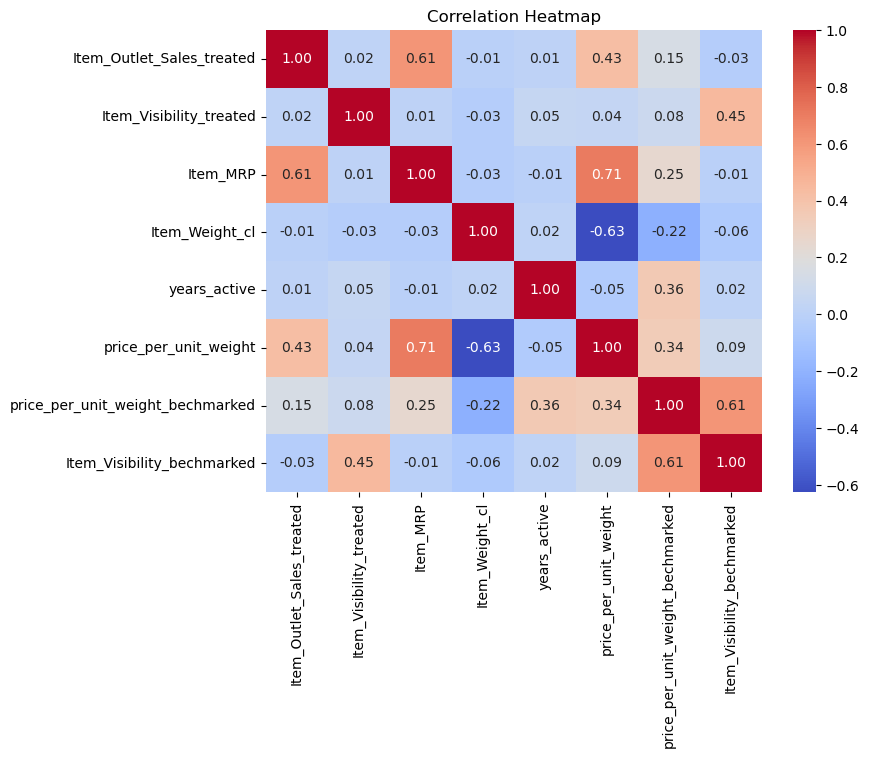

In [12]:
correlation_analysis_features = ['Item_Outlet_Sales_treated', 'Item_Visibility_treated',
       'Item_MRP', 'Item_Weight_cl', 'years_active', 'price_per_unit_weight', 'price_per_unit_weight_bechmarked',
       'Item_Visibility_bechmarked']
get_correlation_heatmap(groc_train_data, features=correlation_analysis_features)

#### Prediction using Model Stacking of XGBRegressor, Light GBM, Catboost and Random Forest

In [14]:
def create_model_features(df, y, features, drop_columns):
    model_train_data = pd.get_dummies(df[features])
    model_train_data.drop(columns=drop_columns,inplace=True)
    
    X_train, X_test, y_train, y_test = train_test_split(model_train_data, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [15]:
# Define a custom RMSE scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [16]:
def train_xgb_model(X_train, X_test, y_train, y_test):
    xgb_model = XGBRegressor(random_state=42)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [2, 3, 5],
        'learning_rate': [0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'reg_alpha': [5, 10],
        'reg_lambda': [1, 5]
    }

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring=rmse_scorer,
        cv=3,
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    print("Best Hyperparameters:", grid_search.best_params_)
    best_xgb_model = grid_search.best_estimator_
    y_pred = (best_xgb_model.predict(X_test))
    y_test = (y_test)
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(f"Test RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")
    xgb.plot_importance(best_xgb_model)
    plt.show()
    return best_xgb_model

In [17]:
def train_lgb_model(X_train, X_test, y_train, y_test):
    lgb_param_grid = {
        'n_estimators': [50, 100],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5, 7],
        'num_leaves': [15, 31, 63],
        'reg_alpha': [1, 5, 10],
        'reg_lambda': [1, 5]
    }
    
    lgb_search = RandomizedSearchCV(
        estimator=lgb.LGBMRegressor(),
        param_distributions=lgb_param_grid,
        n_iter=20,
        scoring=rmse_scorer,
        cv=5,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    
    lgb_search.fit(X_train, y_train)
    best_lgb_model = lgb_search.best_estimator_
    print("Best LightGBM Params:", lgb_search.best_params_)
    
    y_pred = (best_lgb_model.predict(X_test))
    y_test = (y_test)
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(f"Test RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")
    
    lgb_importance = pd.Series(best_lgb_model.feature_importances_, index=X_train.columns)
    lgb_importance_sorted = lgb_importance.sort_values(ascending=True)
    
    plt.figure(figsize=(8, 10))
    lgb_importance_sorted.plot(kind='barh')
    plt.title('LightGBM Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()
    return best_lgb_model

In [18]:
def train_cat_model(X_train, X_test, y_train, y_test):
    cat_param_grid = {
        'n_estimators': [50, 100],
        'learning_rate': [0.05, 0.1],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [1, 3, 5, 7] 
    }
    
    cat_search = RandomizedSearchCV(
        estimator=cb.CatBoostRegressor(verbose=0),
        param_distributions=cat_param_grid,
        n_iter=20,
        scoring=rmse_scorer,
        cv=5,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    
    cat_search.fit(X_train, y_train)
    best_cat_model = cat_search.best_estimator_
    print("Best CatBoost Params:", cat_search.best_params_)
    
    y_pred = (best_cat_model.predict(X_test))
    y_test = (y_test)
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(f"Test RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")
    
    cat_importance = pd.Series(best_cat_model.feature_importances_, index=X_train.columns)
    cat_importance_sorted = cat_importance.sort_values(ascending=True)
    
    plt.figure(figsize=(8, 10))
    cat_importance_sorted.plot(kind='barh')
    plt.title('LightGBM Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()
    return best_cat_model

In [19]:
def train_rf_model(X_train, X_test, y_train, y_test):
    # Random Forest
    rf_param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 0.5] 
    }
    
    rf_search = RandomizedSearchCV(
        estimator=RandomForestRegressor(),
        param_distributions=rf_param_grid,
        n_iter=20,
        scoring='neg_root_mean_squared_error',
        cv=5,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    
    rf_search.fit(X_train, y_train)
    best_rf_model = rf_search.best_estimator_
    print("Best RandomForest Params:", rf_search.best_params_)
    
    y_pred = (best_rf_model.predict(X_test))
    y_test = (y_test)
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(f"Test RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")
    
    rf_importance = pd.Series(best_rf_model.feature_importances_, index=X_train.columns)
    rf_importance_sorted = rf_importance.sort_values(ascending=True)
    
    plt.figure(figsize=(8, 10))
    rf_importance_sorted.plot(kind='barh')
    plt.title('LightGBM Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()
    return best_rf_model

In [20]:
def train_meta_model(best_xgb_model, best_lgb_model, best_cat_model, best_rf_model, k_fold):
    """
    Meta model by stacking the best XGB, LGB, Catboost and RF models along with k-fold cross validation
    """
    base_models = [
        ('xgb', best_xgb_model),
        ('lgb', best_lgb_model),
        ('cat', best_cat_model),
        ('rf', best_rf_model)
    ]
    
    # k-fold cross validation
    n_splits = k_fold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Initialize out of fold containers
    oof_train = np.zeros((X_train.shape[0], len(base_models)))
    oof_test = np.zeros((X_test.shape[0], len(base_models)))
    
    for i, (name, model) in enumerate(base_models):
        oof_test_i = np.zeros((X_test.shape[0], n_splits))
        for j, (train_idx, val_idx) in enumerate(kf.split(X_train)):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            model.fit(X_tr, y_tr)
            oof_train[val_idx, i] = model.predict(X_val)
            oof_test_i[:, j] = model.predict(X_test)
        
        # Average test predictions across folds
        oof_test[:, i] = oof_test_i.mean(axis=1)
    
    # Train meta-model on OOF predictions
    meta_model = RidgeCV()
    meta_model.fit(oof_train, y_train)
    
    # Final predictions on test set
    final_pred = meta_model.predict(oof_test)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, final_pred))
    print(f"Cross-validated Stacking RMSE: {rmse:.4f}")
    r2 = r2_score(y_test, final_pred)
    print(f"R² Score: {r2:.2f}")
    return y_test, final_pred, meta_model

In [21]:
def analyze_residuals(actuals, predicted):
    residuals = actuals - predicted

    # Distribution of residuals
    sns.histplot(residuals, kde=True)
    plt.title('Distribution of Residuals')
    plt.show()

    # QQPlot
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('QQ Plot of Residuals')
    plt.show()

In [33]:
model_features = ['Item_Weight_cl', 'Item_Fat_Content_cl', 
            'Item_Visibility_treated',
           'Item_Category',
            # 'Item_Type',
            'Item_MRP',
            # 'price_per_unit_weight',
            # 'years_active',
            # 'Outlet_Size',
            'Outlet_Location_Type',
            # 'Outlet_Type',
            'price_per_unit_weight_bechmarked',
       # 'Item_Visibility_bechmarked'
           ]
dummy_variables = ['Item_Fat_Content_cl_non_consumable',
                'Item_Category_NC',
                # 'Item_Type_Others',
                'Outlet_Location_Type_Tier 3']
X_train, X_test, y_train, y_test = create_model_features(groc_train_data, y=groc_train_data["Item_Outlet_Sales"],features=model_features, drop_columns=dummy_variables)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50, 'reg_alpha': 5, 'reg_lambda': 1, 'subsample': 1.0}
Test RMSE: 221.01
R² Score: 0.21


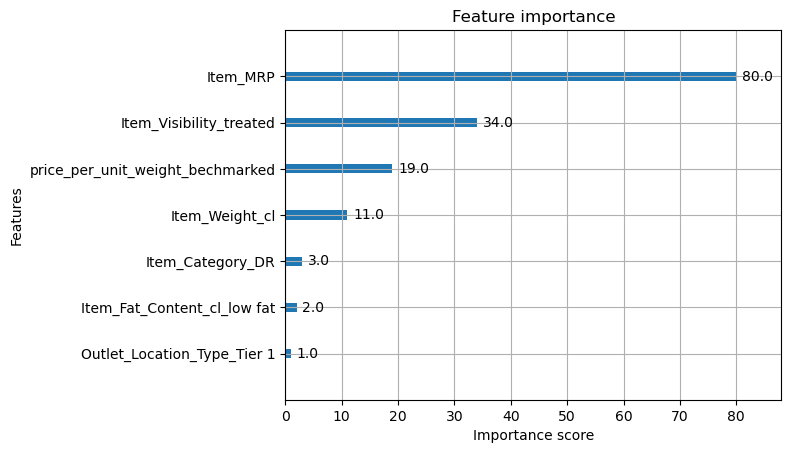

In [35]:
best_xgb_model = train_xgb_model(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


  File "C:\Users\Daniel\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Daniel\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Daniel\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Daniel\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 866, number of used features: 9
[LightGBM] [Info] Start training from score 339.035970
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

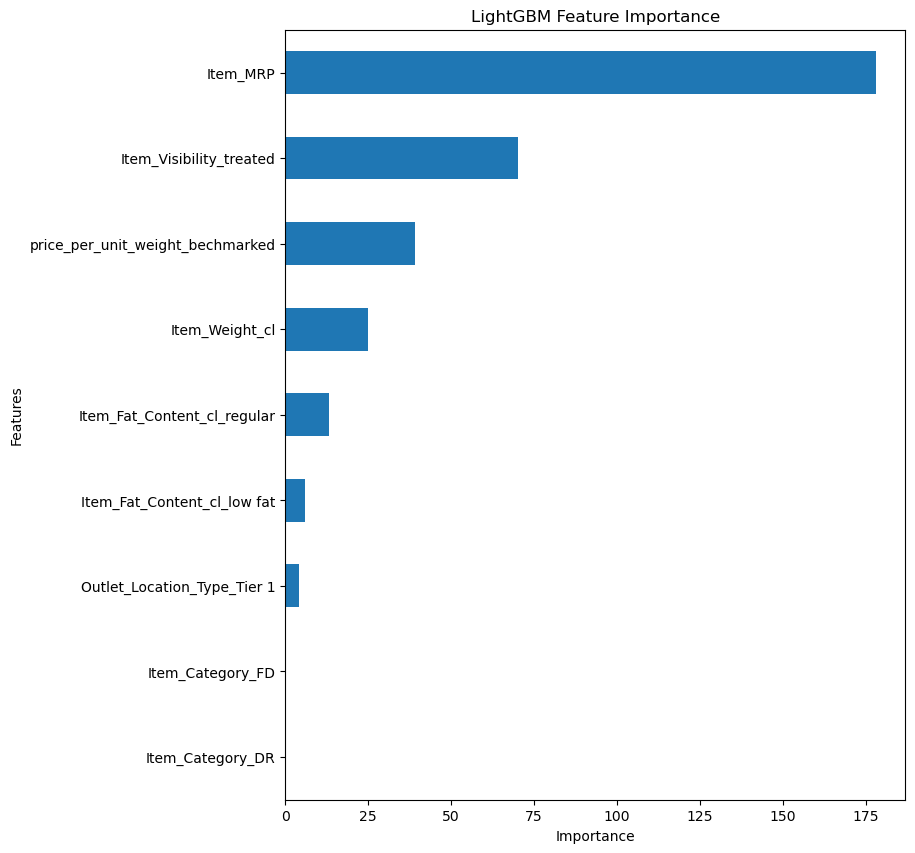

In [37]:
best_lgb_model = train_lgb_model(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CatBoost Params: {'n_estimators': 50, 'learning_rate': 0.05, 'l2_leaf_reg': 5, 'depth': 4}
Test RMSE: 218.40
R² Score: 0.23


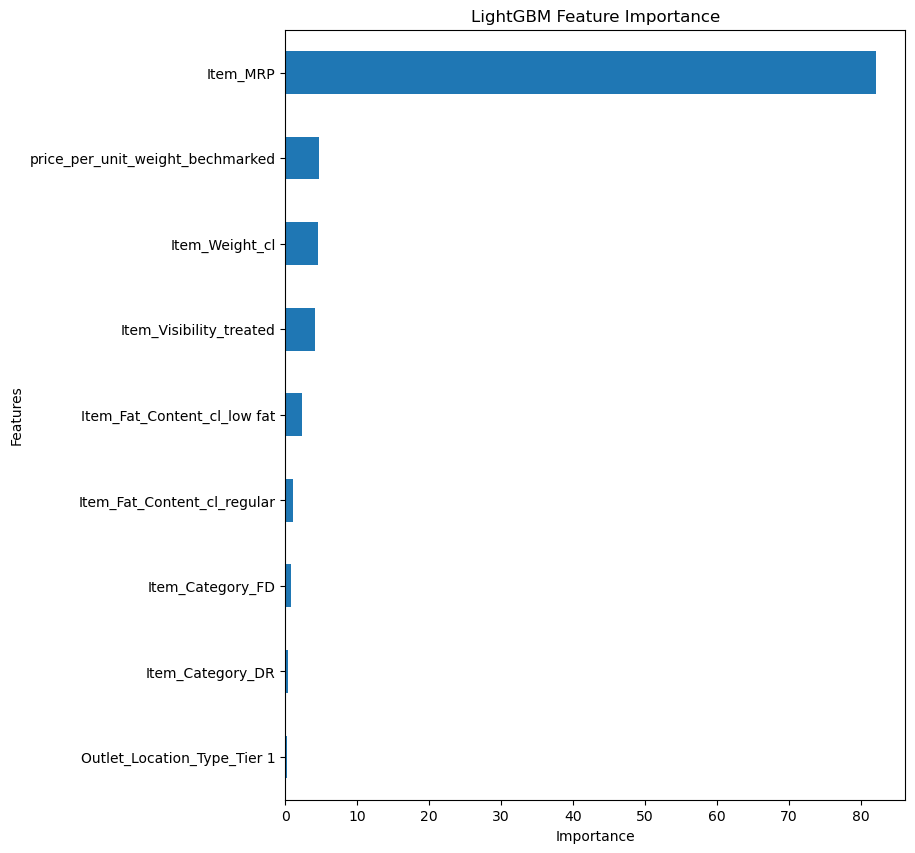

In [38]:
best_cat_model = train_cat_model(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RandomForest Params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 5}
Test RMSE: 220.01
R² Score: 0.22


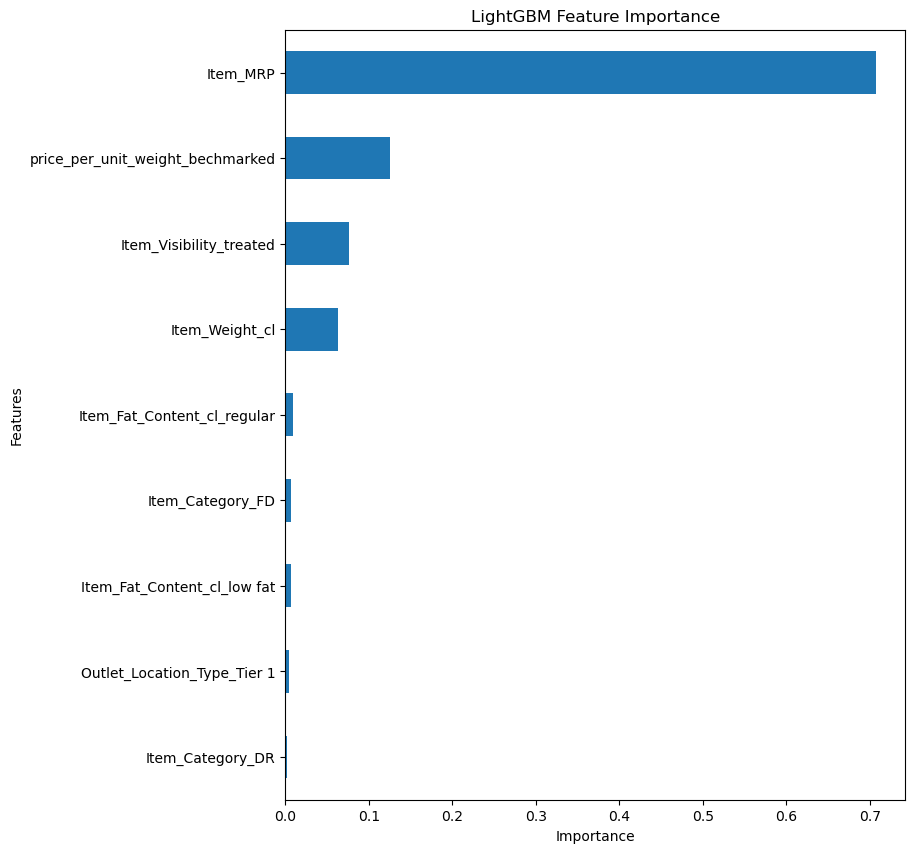

In [39]:
best_rf_model = train_rf_model(X_train, X_test, y_train, y_test)

In [40]:
y_test, final_pred, final_meta_model = train_meta_model(best_xgb_model, best_lgb_model, best_cat_model, best_rf_model, k_fold=5)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 744
[LightGBM] [Info] Number of data points in the train set: 692, number of used features: 9
[LightGBM] [Info] Start training from score 334.633774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

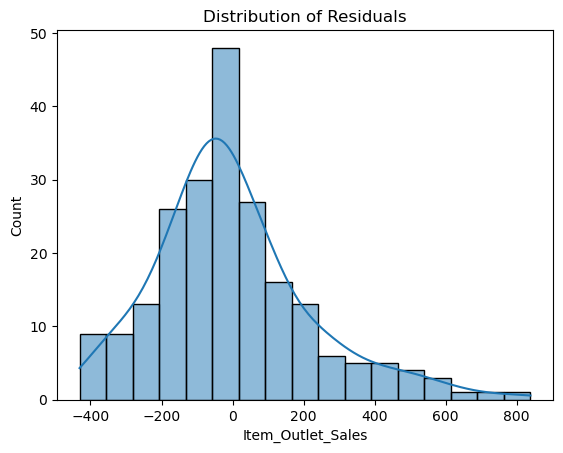

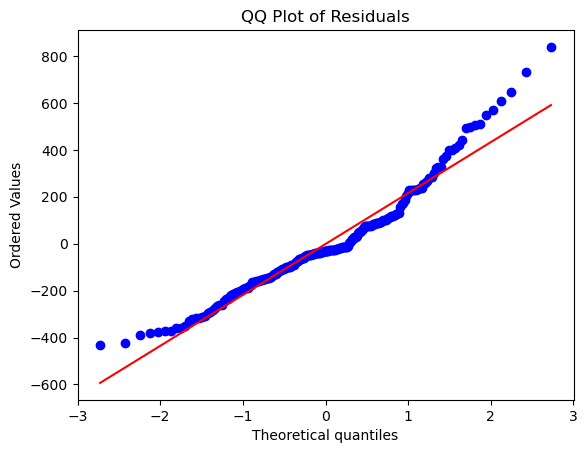

In [41]:
analyze_residuals(y_test, final_pred)

#### Predict Meta model on the test data

In [47]:
# Read test data and filter for non grocery stores
test_data = pd.read_csv("../data/test_AbJTz2l.csv")
groc_test_data = test_data.loc[test_data["Outlet_Type"]=="Grocery Store",:]

In [48]:
groc_test_data = clean_df(groc_test_data)

In [49]:
def get_test_df(df, features, drop_columns, X_train, X_test, y_train, y_test):
    test_df = pd.get_dummies(df[features])
    test_df.drop(columns=drop_columns,inplace=True)
    X_full = pd.concat([X_train, X_test])
    y_full = pd.concat([y_train, y_test])
    return test_df, X_full, y_full

In [50]:
def get_final_predictions(test_df, X_full, y_full, base_models ,final_meta_model):
    real_test_preds = np.zeros((test_df.shape[0], len(base_models)))
    for i, (name, model) in enumerate(base_models):
        model.fit(X_full, y_full)
        # Predict on real test set
        real_test_preds[:, i] = model.predict(test_df)
    final_predictions = final_meta_model.predict(real_test_preds)
    return final_predictions

In [51]:
test_df, X_full, y_full = get_test_df(groc_test_data, model_features, dummy_variables, X_train, X_test, y_train, y_test)

In [52]:
base_models = [
        ('xgb', best_xgb_model),
        ('lgb', best_lgb_model),
        ('cat', best_cat_model),
        ('rf', best_rf_model)
    ]

In [53]:
model_features

['Item_Weight_cl',
 'Item_Fat_Content_cl',
 'Item_Visibility_treated',
 'Item_Category',
 'Item_MRP',
 'Outlet_Location_Type',
 'price_per_unit_weight_bechmarked']

In [54]:
test_df.columns

Index(['Item_Weight_cl', 'Item_Visibility_treated', 'Item_MRP',
       'price_per_unit_weight_bechmarked', 'Item_Fat_Content_cl_low fat',
       'Item_Fat_Content_cl_regular', 'Item_Category_DR', 'Item_Category_FD',
       'Outlet_Location_Type_Tier 1'],
      dtype='object')

In [55]:
y_real_pred = get_final_predictions(test_df, X_full, y_full, base_models ,final_meta_model)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 9
[LightGBM] [Info] Start training from score 339.828501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [56]:
groc_submission = groc_test_data[["Item_Identifier","Outlet_Identifier"]]
groc_submission["Item_Outlet_Sales"] = y_real_pred

In [67]:
groc_submission.to_csv("../output/Daniel_final_submission_groc.csv",index=None)

In [ ]:
# Collate submissions from both Supermarkets and Groceries

In [69]:
nongroc_submission = pd.read_csv("../output/Daniel_final_submission_nongroc.csv")
final_submission = pd.concat([nongroc_submission,groc_submission],axis=0)
final_submission.to_csv("../output/Daniel_final_submission.csv",index=None)